In [15]:
import torch
from torch.autograd import grad
import torch.nn as nn
from numpy import genfromtxt
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
torch.set_printoptions(precision=6)

hiv_data = genfromtxt('hiv.csv', delimiter=',') #in the form of [t, T, I, V]

torch.manual_seed(1234)

In [16]:
%%time

PATH = 'hiv' 

class DINN(nn.Module):
    def __init__(self, t, T_data, I_data, V_data): 
        super(DINN, self).__init__()
        self.t = torch.tensor(t, requires_grad=True)
        self.t_float = self.t.float()
        self.t_batch = torch.reshape(self.t_float, (len(self.t),1)) #reshape for batch 
        self.T = torch.tensor(T_data) 
        self.I = torch.tensor(I_data) 
        self.V = torch.tensor(V_data) 

        self.losses = [] #keep the losses
        self.save = 2 #which file to save to
 
        #learnable parameters
        self.s_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.mu_T_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.mu_I_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.mu_b_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.mu_V_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.r_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.N_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.T_max_param_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.k1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.k1_prime_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))

        #matrices (x3 for T,I,V) for the gradients
        self.m1 = torch.zeros((len(self.t), 3)); self.m1[:, 0] = 1
        self.m2 = torch.zeros((len(self.t), 3)); self.m2[:, 1] = 1
        self.m3 = torch.zeros((len(self.t), 3)); self.m3[:, 2] = 1

        #values for norm
        self.T_max = max(self.T)
        self.I_max = max(self.I)
        self.V_max = max(self.V)        
        self.T_min = min(self.T)
        self.I_min = min(self.I)
        self.V_min = min(self.V)    

        #normalize 
        self.T_hat = (self.T - self.T_min) / (self.T_max - self.T_min)
        self.I_hat = (self.I - self.I_min) / (self.I_max - self.I_min)
        self.V_hat = (self.V - self.V_min) / (self.V_max - self.V_min)

        #NN
        self.net_hiv = self.Net_hiv()
        self.params = list(self.net_hiv.parameters())
        self.params.extend(list([self.s_tilda, self.mu_T_tilda, self.mu_I_tilda, self.mu_b_tilda, self.mu_V_tilda, self.r_tilda, self.N_tilda, self.T_max_param_tilda, self.k1_tilda, self.k1_prime_tilda]))


    #force parameters to be in a range
    @property
    def s(self):
        return torch.tanh(self.s_tilda) * 0.1 + 10

    @property
    def mu_T(self):
        return torch.tanh(self.mu_T_tilda) * 0.002 + 0.02

    @property
    def mu_I(self):
        return torch.tanh(self.mu_I_tilda) * 0.005 + 0.26

    @property
    def mu_b(self):
        return torch.tanh(self.mu_b_tilda) * 0.005 + 0.24

    @property
    def mu_V(self):
        return torch.tanh(self.mu_V_tilda) * 0.1 + 2.4

    @property
    def r(self):
        return torch.tanh(self.r_tilda) * 0.001 + 0.03 

    @property
    def N(self):
        return torch.tanh(self.N_tilda) * 2.5 + 250

    @property
    def T_max_param(self):
        return torch.tanh(self.T_max_param_tilda) * 15 + 1500

    @property
    def k1(self):
        return torch.tanh(self.k1_tilda) * 1*10e-6 + 2.4*10e-5

    @property
    def k1_prime(self):
        return torch.tanh(self.k1_prime_tilda) * 1*10e-6 + 2*10e-5
    
    #nets
    class Net_hiv(nn.Module): # input = [t]
        def __init__(self):
            super(DINN.Net_hiv, self).__init__()
            self.fc1=nn.Linear(1, 20) #takes t's
            self.fc2=nn.Linear(20, 20)
            self.fc3=nn.Linear(20, 20)
            self.fc4=nn.Linear(20, 20)
            self.fc5=nn.Linear(20, 20)
            self.fc6=nn.Linear(20, 20)
            self.fc7=nn.Linear(20, 20)
            self.fc8=nn.Linear(20, 20)
            self.out=nn.Linear(20, 3) #outputs T, I, V

        def forward(self, t):
            tiv=F.relu(self.fc1(t))
            tiv=F.relu(self.fc2(tiv))
            tiv=F.relu(self.fc3(tiv))
            tiv=F.relu(self.fc4(tiv))
            tiv=F.relu(self.fc5(tiv))
            tiv=F.relu(self.fc6(tiv))
            tiv=F.relu(self.fc7(tiv))
            tiv=F.relu(self.fc8(tiv))
            tiv=self.out(tiv)
            return tiv    

    def net_f(self, t_batch):       
        tiv_hat = self.net_hiv(t_batch)

        T_hat, I_hat, V_hat = tiv_hat[:,0], tiv_hat[:,1], tiv_hat[:,2]

        #T_t
        tiv_hat.backward(self.m1, retain_graph=True)
        T_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #I_t
        tiv_hat.backward(self.m2, retain_graph=True)
        I_hat_t = self.t.grad.clone()
        self.t.grad.zero_()
        
        #V_t
        tiv_hat.backward(self.m3, retain_graph=True)
        V_hat_t = self.t.grad.clone()
        self.t.grad.zero_()
        
        #unnormalize
        T = self.T_min + (self.T_max - self.T_min) * T_hat
        I = self.I_min + (self.I_max - self.I_min) * I_hat
        V = self.V_min + (self.V_max - self.V_min) * V_hat

        f1_hat = T_hat_t - (self.s - self.mu_T * T + self.r * T * (1 - ((T + I) / self.T_max_param) - self.k1 * V * T)) / (self.T_max_param - self.T_min) 
        f2_hat = I_hat_t - (self.k1_prime * V * T - self.mu_I * I) / (self.I_max - self.I_min)         
        f3_hat = V_hat_t - (self.N * self.mu_b * I - self.k1 * V * T - self.mu_V * V) / (self.V_max - self.V_min)         

        return f1_hat, f2_hat, f3_hat, T_hat, I_hat, V_hat
    
    def load(self):
      # Load checkpoint
      try:
        checkpoint = torch.load(PATH + str(self.save)+'.pt') 
        print('\nloading pre-trained model...')
        self.load_state_dict(checkpoint['model'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler'])
        epoch = checkpoint['epoch']
        loss = checkpoint['loss']
        self.losses = checkpoint['losses']
        print('loaded previous loss: ', loss)
      except RuntimeError :
          print('changed the architecture, ignore')
          pass
      except FileNotFoundError:
          pass

    def train(self, n_epochs):
      #try loading
      self.load()

      #train
      print('\nstarting training...\n')
      
      for epoch in range(n_epochs):
        #lists to hold the output (maintain only the final epoch)
        T_pred_list= []
        I_pred_list= []
        V_pred_list= []


        f1, f2, f3, T_pred, I_pred, V_pred = self.net_f(self.t_batch)
        self.optimizer.zero_grad()

        T_pred_list.append(self.T_min + (self.T_max - self.T_min) * T_pred) 
        I_pred_list.append(self.I_min + (self.I_max - self.I_min) * I_pred)
        V_pred_list.append(self.V_min + (self.V_max - self.V_min) * V_pred)

        loss = (torch.mean(torch.square(self.T_hat - T_pred)) + torch.mean(torch.square(self.I_hat - I_pred)) + torch.mean(torch.square(self.V_hat - V_pred)) + 
               torch.mean(torch.square(f1)) + torch.mean(torch.square(f2)) + torch.mean(torch.square(f3)))

        loss.backward()

        self.optimizer.step()
        self.scheduler.step() 
        #self.scheduler.step(loss) 

        self.losses.append(loss.item())

        if epoch % 1000 == 0:          
          print('\nEpoch ', epoch)

        #loss + model parameters update
        if epoch % 4000 == 9999:
          #checkpoint save every 1000 epochs if the loss is lower
          print('\nSaving model... Loss is: ', loss)
          torch.save({
              'epoch': epoch,
              'model': self.state_dict(),
              'optimizer_state_dict': self.optimizer.state_dict(),
              'scheduler': self.scheduler.state_dict(),
              'loss': loss,
              'losses': self.losses,
              }, PATH + str(self.save)+'.pt')
          if self.save % 2 > 0: #its on 3
            self.save = 2 #change to 2
          else: #its on 2
            self.save = 3 #change to 3

          print('epoch: ', epoch)
          print('s: (goal 10)', self.s)
          print('\nmu_T: (goal 0.02)', self.mu_T)
          print('\nmu_I: (goal 0.26): ', self.mu_I)
          print('\nmu_b (goal 0.24): ', self.mu_b)
          print('\nmu_V: (goal 2.4): ', self.mu_V)
          print('\nr (goal 0.03): ', self.r)
          print('\nN (goal 250): ', self.N)
          print('\nT_max (goal 1500): ', self.T_max_param)
          print('\nk1 (goal 2.4*10e-5): ', self.k1)
          print('\nk1_prime (goal 2*10e-5): ', self.k1_prime)
          print('#################################')
        
      #plot
      plt.plot(self.losses, color = 'teal')
      plt.xlabel('Epochs')
      plt.ylabel('Loss')
      return T_pred_list, I_pred_list, V_pred_list

CPU times: user 74 µs, sys: 0 ns, total: 74 µs
Wall time: 81.1 µs



loading pre-trained model...
loaded previous loss:  tensor(0.003001, dtype=torch.float64, requires_grad=True)

starting training...


Epoch  0
CPU times: user 6.7 s, sys: 1.04 s, total: 7.74 s
Wall time: 7.86 s


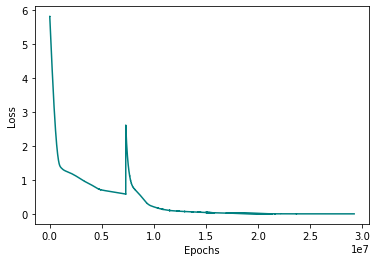

In [17]:
%%time

#this worked best
dinn = DINN(hiv_data[0], hiv_data[1], hiv_data[2], hiv_data[3]) #t, T_data, I_data, V_data

learning_rate = 1e-5
optimizer = optim.Adam(dinn.params, lr = learning_rate)
dinn.optimizer = optimizer

#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(dinn.optimizer, factor=0.99, patience = 5000, verbose=True)
#scheduler = torch.optim.lr_scheduler.CyclicLR(dinn.optimizer, base_lr=1e-7, max_lr=1e-5, step_size_up=20000, mode="triangular2", cycle_momentum=False)
scheduler = torch.optim.lr_scheduler.CyclicLR(dinn.optimizer, base_lr=1e-8, max_lr=1e-3, step_size_up=10000, mode="exp_range", gamma=0.95, cycle_momentum=False)

dinn.scheduler = scheduler

try: 
  T_pred_list, I_pred_list, V_pred_list = dinn.train(1) #train
except EOFError:
  if dinn.save == 2:
    dinn.save = 3
    T_pred_list, I_pred_list, V_pred_list = dinn.train(1) #train
  elif dinn.save == 3:  
    dinn.save = 2
    T_pred_list, I_pred_list, V_pred_list = dinn.train(1) #train

Text(0, 0.5, 'Loss')

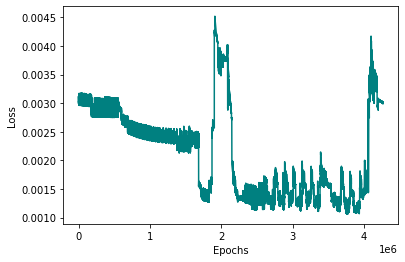

In [18]:
plt.plot(dinn.losses[25000000:], color = 'teal')
plt.xlabel('Epochs')
plt.ylabel('Loss')

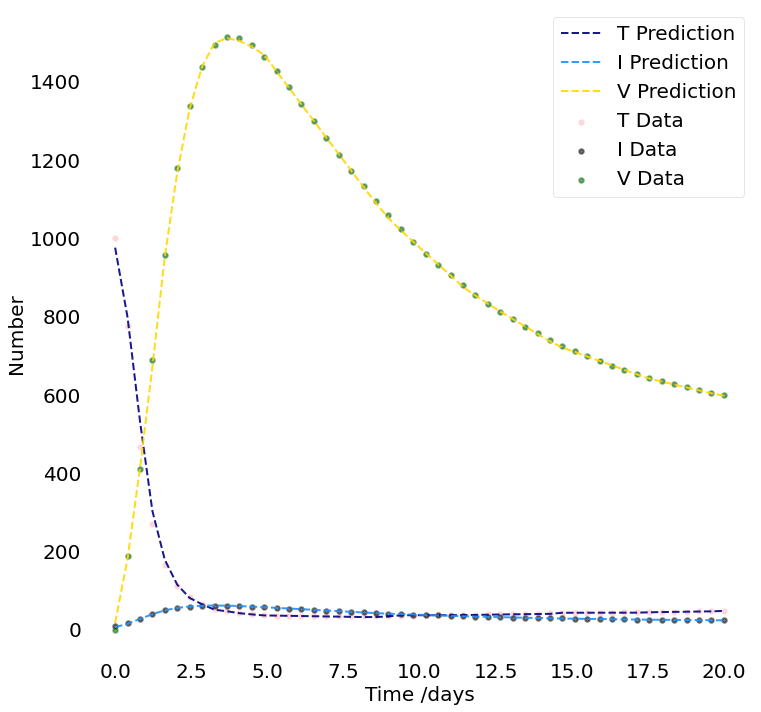

In [24]:
fig = plt.figure(figsize=(12,12))

ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.set_facecolor('xkcd:white')

ax.scatter(hiv_data[0], hiv_data[1], color = 'pink', alpha=0.5, lw=2, label='T Data', s=20)
ax.plot(hiv_data[0], T_pred_list[0].detach().numpy(), 'navy', alpha=0.9, lw=2, label='T Prediction', linestyle='dashed')

ax.scatter(hiv_data[0], hiv_data[2], color = 'black', alpha=0.5, lw=2, label='I Data', s=20)
ax.plot(hiv_data[0], I_pred_list[0].detach().numpy(), 'dodgerblue', alpha=0.9, lw=2, label='I Prediction', linestyle='dashed')

ax.scatter(hiv_data[0], hiv_data[3], color = 'darkgreen', alpha=0.5, lw=2, label='V Data', s=20)
ax.plot(hiv_data[0], V_pred_list[0].detach().numpy(), 'gold', alpha=0.9, lw=2, label='V Prediction', linestyle='dashed')


ax.set_xlabel('Time /days',size = 20)
ax.set_ylabel('Number',size = 20)
#ax.set_ylim([-1,50])
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
plt.xticks(size = 20)
plt.yticks(size = 20)
# ax.grid(b=True, which='major', c='black', lw=0.2, ls='-')
legend = ax.legend(prop={'size':20})
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.savefig('hiv.pdf')
plt.show()

0.03
tensor([0.000246], grad_fn=<AddBackward0>)
tensor([0.000203], grad_fn=<AddBackward0>)


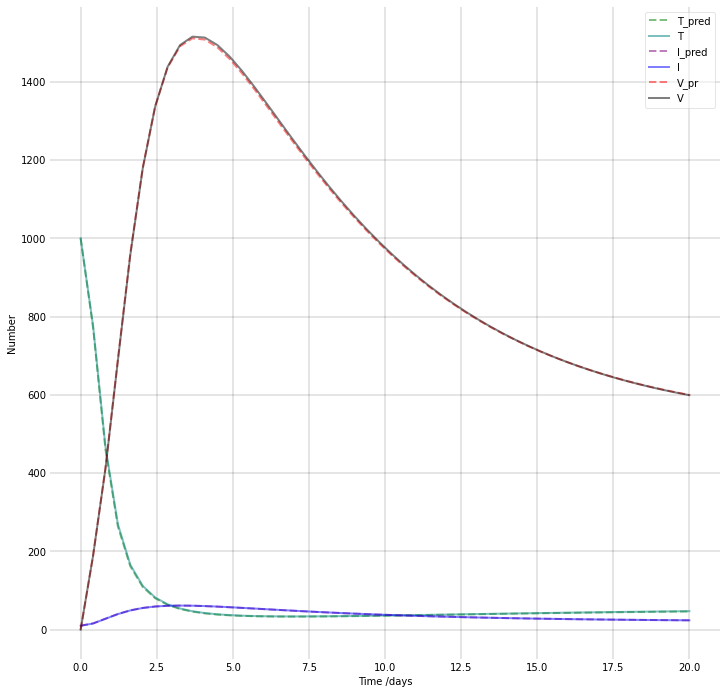

In [20]:
#vaccination! 

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Initial conditions
T0 = 1000
I0 = 10
V0 = 10e-3

# A grid of time points (in days)
t = np.linspace(0, 20, 50) 

#parameters
s = dinn.s
mu_T = dinn.mu_T
mu_I = 0.26 #dinn.mu_I
mu_b = 0.24 #dinn.mu_b
mu_V = 2.4 #dinn.mu_V
r = 0.03 #dinn.r
N = dinn.N
T_max = dinn.T_max_param
k1 = dinn.k1
k1_prime = dinn.k1_prime

print(r)
print(k1)
print(k1_prime)
# mu_I: (goal 0.26):  tensor([0.262541], grad_fn=<AddBackward0>)

# mu_b (goal 0.24):  tensor([2.403510], grad_fn=<AddBackward0>)

# mu_V: (goal 2.4):  tensor([2.400731], grad_fn=<AddBackward0>)

# r (goal 0.03):  tensor([0.030605], grad_fn=<AddBackward0>)


"""s = 10
mu_T = 0.02
mu_I = 0.26
mu_b = 0.24
mu_V = 2.4
r = 0.03
N = 250
T_max = 1500
k1 = 2.4*10e-5
k1_prime = 2*10e-5"""

# The SIR model differential equations.
def deriv(y, t, s, mu_T, mu_V, mu_b, r, N, T_max, k1, k1_prime):
    T, I, V = y
    dTdt = s - mu_T * T + r * T * (1 - ((T + I) / T_max) - k1 * V * T)
    dIdt = k1_prime * V * T - mu_I * I
    dVdt = N * mu_b * I - k1 * V * T - mu_V * V

    return dTdt, dIdt, dVdt


# Initial conditions vector
y0 = T0, I0, V0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(s, mu_T, mu_V, mu_b, r, N, T_max, k1, k1_prime))
T, I, V = ret.T

# Plot the data on two separate curves for S(t), I(t)
fig = plt.figure(figsize=(12,12))

ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.set_facecolor('xkcd:white')

ax.plot(t, T, 'green', alpha=0.5, lw=2, label='T_pred', linestyle='dashed')
ax.plot(hiv_data[0], hiv_data[1], 'teal', alpha=0.5, lw=2, label='T')

ax.plot(t, I, 'purple', alpha=0.5, lw=2, label='I_pred', linestyle='dashed')
ax.plot(hiv_data[0], hiv_data[2], 'blue', alpha=0.5, lw=2, label='I')

ax.plot(t, V, 'red', alpha=0.5, lw=2, label='V_pr', linestyle='dashed')
ax.plot(hiv_data[0], hiv_data[3], 'black', alpha=0.5, lw=2, label='V')

ax.set_xlabel('Time /days')
ax.set_ylabel('Number')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='black', lw=0.2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

In [21]:
#calculate relative MSE loss
import math

T_total_loss = 0
T_den = 0
I_total_loss = 0
I_den = 0
V_total_loss = 0
V_den = 0

for timestep in range(len(t)):
  T_value = hiv_data[1][timestep] - T[timestep]
  T_total_loss += T_value**2
  T_den += (hiv_data[1][timestep])**2
  I_value = hiv_data[2][timestep] - I[timestep]
  I_total_loss += I_value**2
  I_den += (hiv_data[2][timestep])**2
  V_value = hiv_data[3][timestep] - V[timestep]
  V_total_loss += V_value**2
  V_den += (hiv_data[3][timestep])**2

T_total_loss = math.sqrt(T_total_loss/T_den)
I_total_loss = math.sqrt(I_total_loss/I_den)
V_total_loss = math.sqrt(V_total_loss/V_den)

print('T_total_loss: ', T_total_loss)
print('I_total_loss: ', I_total_loss)
print('V_total_loss: ', V_total_loss)

T_total_loss:  0.00831782529271395
I_total_loss:  0.002566636887304462
V_total_loss:  0.003249524477664549
